In [1]:
# importing packages
import os
from tabnanny import verbose
import numpy as np
import matplotlib.pyplot as plt 
from itertools import compress

import mne
from mne import Epochs, events_from_annotations
import mne_nirs

from mne_nirs.experimental_design import make_first_level_design_matrix
from mne_nirs.statistics import run_glm
from mne_nirs.channels import (get_long_channels, get_short_channels, picks_pair_to_idx)
from mne_nirs.visualisation import plot_nirs_source_detector, plot_glm_surface_projection

Loading /Users/nolanbrady/Desktop/LabResearch/IndependentStudy/DataAnalysis/test-data-direct/2022-09-23_001/2022-09-23_001.snirf
Reading 0 ... 12200  =      0.000 ...  1199.260 secs...


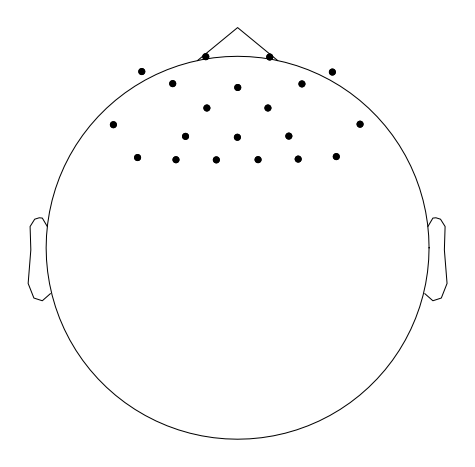

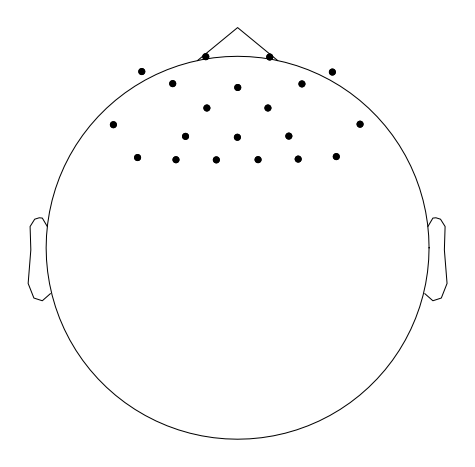

In [2]:
# import raw nirx data
# fname = "/Users/nolanbrady/Documents/NIRx/Data/2022-07-26/2022-07-26_002/2022-07-26_002.snirf"
# fname = "/Users/nolanbrady/Desktop/LabResearch/IndependentStudy/DataAnalysis/test-data-direct/2022-09-23_001/2022-09-23_001.snirf"
fname = "./test-data-direct/2022-09-23_001/2022-09-23_001.snirf"

raw_intensity = mne.io.read_raw_snirf(fname, verbose=True, preload=True)
raw_intensity.plot_sensors()

In [3]:
raw_intensity.info['subject_info']

{'first_name': 'default'}

In [4]:
%matplotlib inline
# Plot the Event Triggers
events, event_dict = mne.events_from_annotations(raw_intensity, verbose=False)
events
event_dict

{'1': 1, '2': 2, '3': 3}

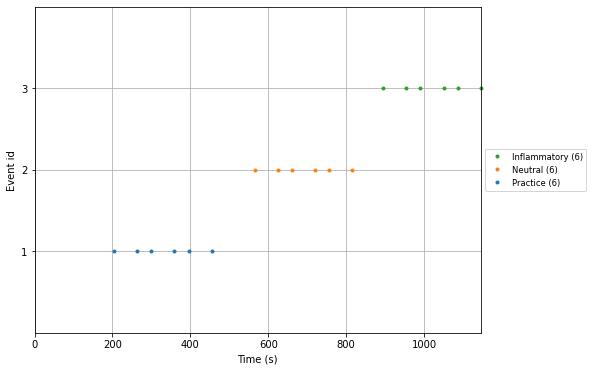

<Annotations | 18 segments: 1 (6), 2 (6), 3 (6)>

In [5]:
# Rename the triggers
# event_dict = {'Control': 4, 'Neutral': 2, 'Inflammatory': 3 }
event_dict = {'Practice': 1, 'Neutral': 2, 'Inflammatory': 3 }
plt.rcParams["figure.figsize"] = (10,6)
mne.viz.plot_events(events, event_id=event_dict, sfreq=raw_intensity.info['sfreq'])

raw_intensity.annotations.set_durations(5) 

In [6]:
# Signal Processing
raw_od = mne.preprocessing.nirs.optical_density(raw_intensity)
raw_od

<RawSNIRF | 2022-09-23_001.snirf, 40 x 12201 (1199.3 s), ~3.9 MB, data loaded>

In [7]:
# Data Quality
sci = mne.preprocessing.nirs.scalp_coupling_index(raw_od)
# sci

Using matplotlib as 2D backend.
Opening raw-browser...


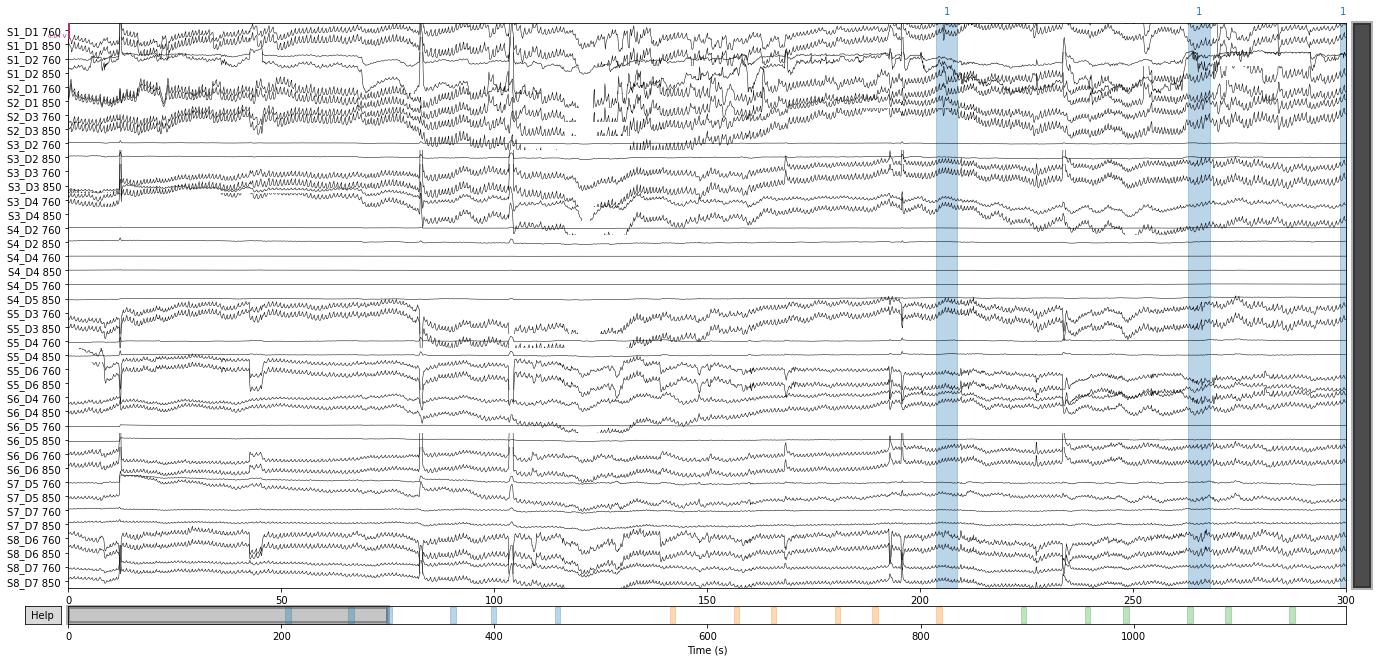

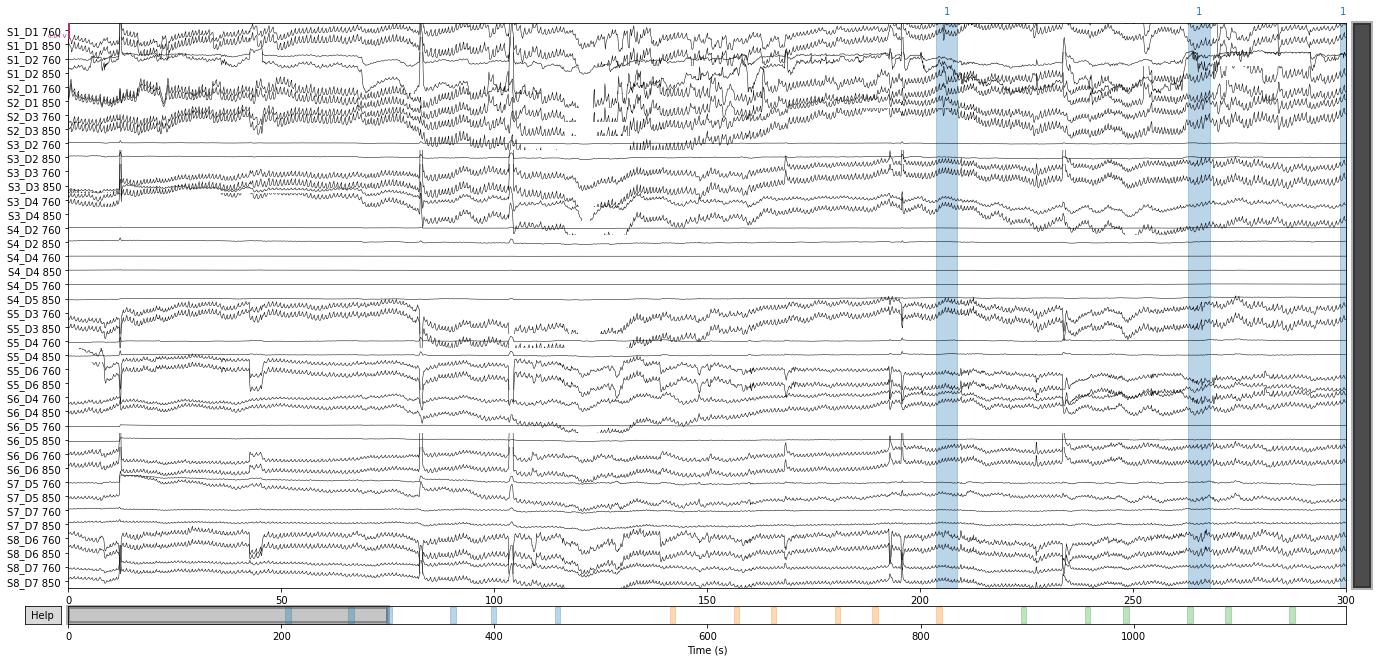

In [8]:
#interactive Data visualization
%matplotlib inline

plt.rcParams['figure.figsize'] = (20,10)
raw_intensity.plot(duration=300, n_channels=len(raw_intensity.ch_names))

Effective window size : 201.318 (s)
Effective window size : 201.318 (s)


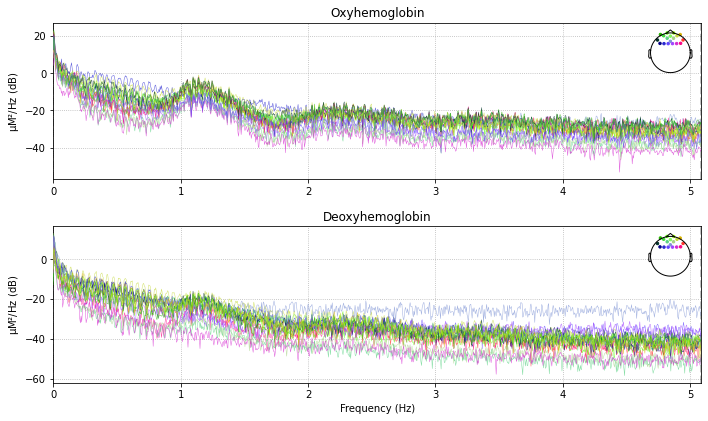

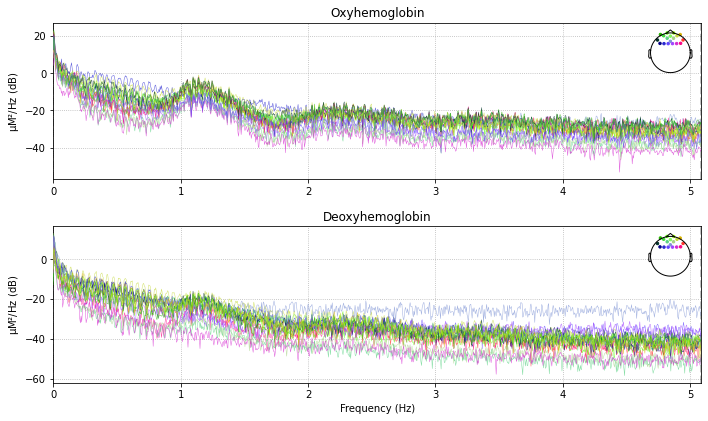

In [9]:
# Wavelength Analysis
raw_od = mne.preprocessing.nirs.optical_density(raw_intensity)
raw_haemo = mne.preprocessing.nirs.beer_lambert_law(raw_od)

raw_haemo = mne_nirs.channels.get_long_channels(raw_haemo)
raw_haemo.plot_psd(average=False)
#X axis is the frequency of the Hertz


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Effective window size : 201.318 (s)
Effective window size : 201.318 (s)


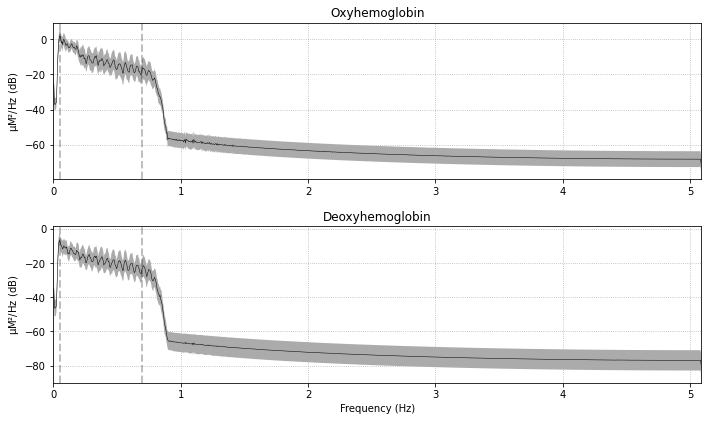

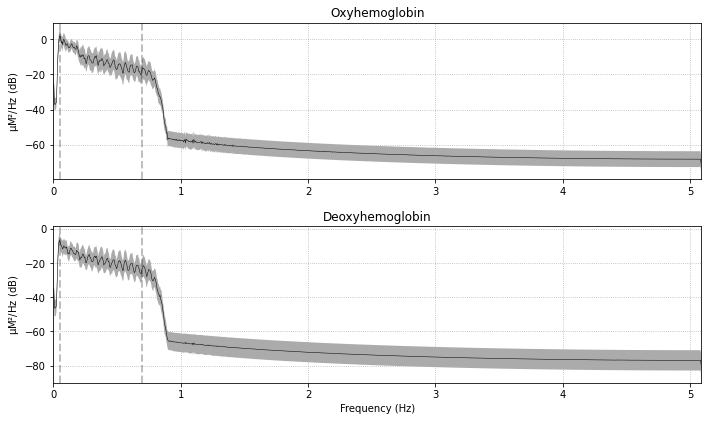

In [10]:
# Filtering Data
raw_haemo = raw_haemo.filter(0.05, 0.7, h_trans_bandwidth=0.2, l_trans_bandwidth=0.02)
raw_haemo.plot_psd(average=True)

In [11]:
# Create Epoches

events, event_id = mne.events_from_annotations(raw_haemo)
event_dict = {'Practice': 1, 'Neutral': 2, 'Inflammatory': 3 }

raw_haemo.annotations.set_durations(5)


Used Annotations descriptions: ['1', '2', '3']


<Annotations | 18 segments: 1 (6), 2 (6), 3 (6)>

In [12]:
reject_criteria = dict(hbo=80e-6)
times = [-2, 0, 2, 4, 6]

epochs = Epochs(raw_haemo, events, event_id=event_dict, tmin=-2, tmax=8,
                    reject=dict(hbo=100e-6), reject_by_annotation=True,
                    proj=True, baseline=(None, 0), detrend=1,
                    preload=True, verbose=False)

No projector specified for this dataset. Please consider the method self.add_proj.


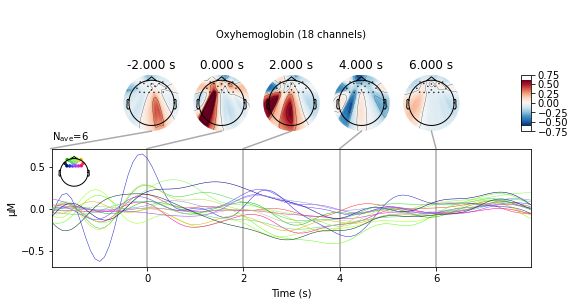

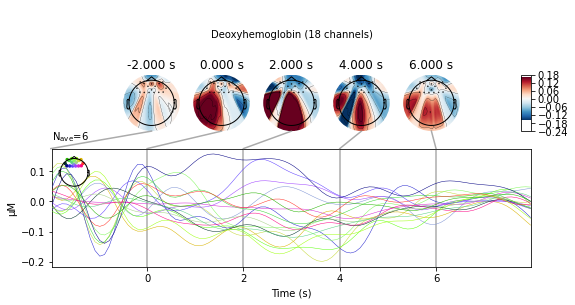

[<Figure size 576x302.4 with 9 Axes>, <Figure size 576x302.4 with 9 Axes>]

In [13]:
epochs['Neutral'].average().plot_joint(times=times)

No projector specified for this dataset. Please consider the method self.add_proj.


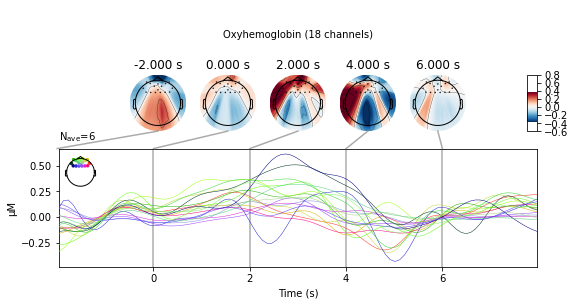

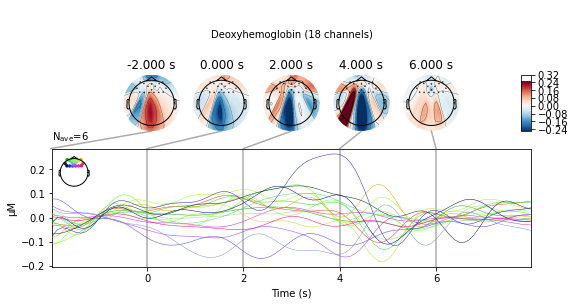

[<Figure size 576x302.4 with 9 Axes>, <Figure size 576x302.4 with 9 Axes>]

In [14]:
epochs['Inflammatory'].average().plot_joint(times=times)

No projector specified for this dataset. Please consider the method self.add_proj.


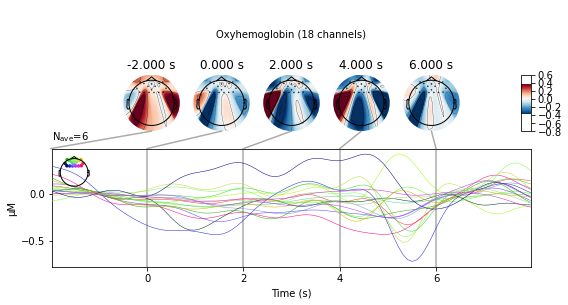

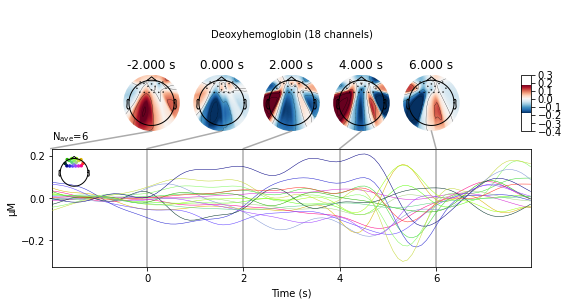

[<Figure size 576x302.4 with 9 Axes>, <Figure size 576x302.4 with 9 Axes>]

In [15]:
epochs['Practice'].average().plot_joint(times=times)

combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


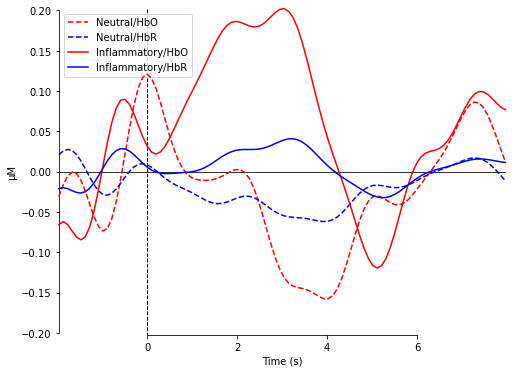

[<Figure size 576x432 with 1 Axes>]

In [16]:
# Plotting all haemodynamic responses on one graph

# evoked_dict = {'Tapping/HbO': epochs['Bionic'].average(picks='hbo').rename_channels(lambda x: x[:-4])}

# mne.viz.plot_compare_evokeds(evoked_dict, combine='mean')

evoked_dict = {
    'Neutral/HbO': epochs['Neutral'].average(picks='hbo'),
    'Neutral/HbR': epochs['Neutral'].average(picks='hbr'),
    'Inflammatory/HbO': epochs['Inflammatory'].average(picks='hbo'),
    'Inflammatory/HbR': epochs['Inflammatory'].average(picks='hbr')}


# Generate the chart
for condition in evoked_dict:
    # print(condition)
    evoked_dict[condition].rename_channels(lambda x: x[:-4])

# Makek HbO red and HbR blue
color_dict = dict(HbO='r', HbR='b')

# Make control condition lines dashed
styles_dict = dict(Neutral=dict(linestyle='dashed'))

mne.viz.plot_compare_evokeds(evoked_dict, combine='mean', colors=color_dict, styles=styles_dict)

In [17]:
# Statistical Analysis

In [18]:
import dabest
import pandas as pd

results = pd.DataFrame()

# Consolidate the Sans Forgetica Epoch data
for epoch in epochs['Practice'].copy().pick('hbo').crop(tmin=-5, tmax=10):
    results = results.append({
        'Value': epoch.mean() * 1e6,
        'Condition': 'Practice'}, ignore_index=True)

# Consolidate the Bionic Epoch data
for epoch in epochs['Neutral'].copy().pick('hbo').crop(tmin=-5, tmax=10):
    results = results.append({
        'Value': epoch.mean() * 1e6,
        'Condition': 'Neutral'}, ignore_index=True)
    
# Consolidate the Control Epoch data
for epoch in epochs['Inflammatory'].copy().pick('hbo').crop(tmin=-5, tmax=10):
    results = results.append({
        'Value': epoch.mean() * 1e6,
        'Condition': 'Inflammatory'}, ignore_index=True)


/var/folders/f_/0f3gmdgs0db0f5gf8gg2874c0000gn/T/ipykernel_52229/1781413210.py:7: RuntimeWarning: tmin is not in epochs time interval. tmin is set to epochs.tmin
  for epoch in epochs['Practice'].copy().pick('hbo').crop(tmin=-5, tmax=10):
/var/folders/f_/0f3gmdgs0db0f5gf8gg2874c0000gn/T/ipykernel_52229/1781413210.py:7: RuntimeWarning: tmax is not in epochs time interval. tmax is set to epochs.tmax
  for epoch in epochs['Practice'].copy().pick('hbo').crop(tmin=-5, tmax=10):
/var/folders/f_/0f3gmdgs0db0f5gf8gg2874c0000gn/T/ipykernel_52229/1781413210.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({
/var/folders/f_/0f3gmdgs0db0f5gf8gg2874c0000gn/T/ipykernel_52229/1781413210.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({
/var/folders/f_/0f3gmdgs0db0f5gf8g

In [19]:
results['ID'] = "P02"
results

,Value,Condition,ID
0,-0.152085,Practice,P02
1,0.054904,Practice,P02
2,-0.113751,Practice,P02
3,-0.125999,Practice,P02
4,0.062973,Practice,P02
5,-0.015681,Practice,P02
6,0.241052,Neutral,P02
7,0.016089,Neutral,P02
8,-0.066481,Neutral,P02
9,-0.120603,Neutral,P02


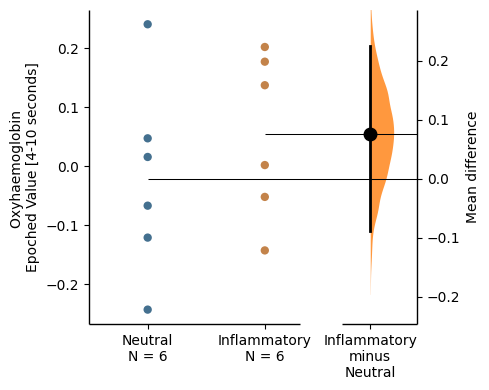

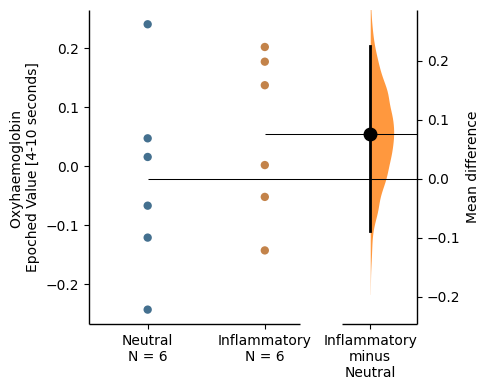

In [20]:
analysis_of_long_df = dabest.load(results, idx=('Neutral', 'Inflammatory'), x = "Condition", y = "Value")
analysis_of_long_df

analysis_of_long_df.mean_diff.plot(swarm_label="Oxyhaemoglobin \nEpoched Value [4-10 seconds]")

In [21]:
analysis_of_long_df.mean_diff

DABEST v0.3.1
             
Good afternoon!
The current time is Fri Oct 14 15:04:04 2022.

The unpaired mean difference between Neutral and Inflammatory is 0.0752 [95%CI -0.0889, 0.225].
The p-value of the two-sided permutation t-test is 0.401. 

5000 bootstrap samples were taken; the confidence interval is bias-corrected and accelerated.
The p-value(s) reported are the likelihood(s) of observing the effect size(s),
if the null hypothesis of zero difference is true.
For each p-value, 5000 reshuffles of the control and test labels were performed.

To get the results of all valid statistical tests, use `.mean_diff.statistical_tests`

In [22]:
# Generate GLM

for items in raw_haemo.annotations:
    item_id = items['description']
    if item_id == '1':
        raw_haemo.annotations.rename({item_id: 'Practice'})
    elif item_id == '2':
        raw_haemo.annotations.rename({item_id: 'Neutral'})
    elif item_id == '3':
        raw_haemo.annotations.rename({item_id: 'Inflammatory'})
        
# raw_haemo.annotations.rename({ 2: 'Bionic', 3: 'Sans Forgetica', 4: 'Control'})
# raw_haemo.annotations[2]

# raw_haemo.annotations.delete(raw_haemo.annotations.description == '2')

design_matrix = make_first_level_design_matrix(raw_haemo,
                                              drift_model='cosine',
                                              high_pass=0.005,
                                              hrf_model='spm',
                                              stim_dur=30.0)


In [23]:
data_subset = raw_haemo.copy()
glm_est = run_glm(data_subset, design_matrix)
glm_est.plot_topo(conditions=['Bionic','Sans_Forgetica', 'Control'])

ValueError: Number of columns must be a positive integer, not 0

<Figure size 864x504 with 0 Axes>

In [ ]:
# See if I can plot the brain

In [ ]:
import statsmodels.formula.api as smf

In [ ]:
df_cha = pd.DataFrame()
ch_summary = df_cha.query("Condition in ['Bionic']")

ch_model = smf.mixedlm("theta ~ -1 + ch_name", ch_summary,
                       groups=ch_summary["ID"]).fit(method='nm')
model_df = statsmodels_to_results(ch_model, order=raw_haemo.copy().pick("hbo").ch_names)

In [ ]:
brain = plot_glm_surface_projection(raw_haemo.copy().pick("hbo"), model_df, colorbar=True)
# brain.add_sensors(raw_haemo.info, trans='fsaverage', fnirs=['channels', 'pairs', 'sources', 'detectors'])

# # mark the premotor cortex in green
# aud_label = [label for label in labels_combined if label.name == 'Premotor Cortex-lh'][0]
# brain.add_label(aud_label, borders=True, color='green')

# # mark the auditory association cortex in blue
# aud_label = [label for label in labels_combined if label.name == 'Auditory Association Cortex-lh'][0]
# brain.add_label(aud_label, borders=True, color='blue')

# brain.show_view(azimuth=160, elevation=60, distance=400)